In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df=pd.read_csv("/kaggle/input/mp-2-clean-dataset/CleanDataset/clean_and_merged_df.csv")

In [3]:
df

,imageid,glaucoma
0,image_0.jpg,0
1,image_1.jpg,0
2,image_3.jpg,0
3,image_4.jpg,0
4,image_5.jpg,0
...,...,...
2465,V0396.jpg,0
2466,V0397.jpg,0
2467,V0398.jpg,0
2468,V0399.jpg,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   imageid   2470 non-null   object
 1   glaucoma  2470 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.7+ KB


In [5]:
df.describe()

,glaucoma
count,2470.000000
mean,0.220243
std,0.414494
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [6]:
df['glaucoma'].value_counts()

glaucoma
0    1926
1     544
Name: count, dtype: int64

In [7]:
df['imageid'].nunique()

2470

In [8]:
# Load the DataFrame
df = pd.read_csv('/kaggle/input/mp-2-clean-dataset/CleanDataset/clean_and_merged_df.csv')

# Define the image directory
image_dir = '/kaggle/input/mp-2-clean-dataset/CleanDataset/Resized_Images/'


In [9]:
# Append the full path to imageid column
df['imageid'] = df['imageid'].apply(lambda x: os.path.join(image_dir, x))


In [10]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['glaucoma'], random_state=42)

In [11]:
# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Convert the 'glaucoma' column to strings
train_df['glaucoma'] = train_df['glaucoma'].astype(str)
val_df['glaucoma'] = val_df['glaucoma'].astype(str)

# Create training and validation data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='imageid',
    y_col='glaucoma',
    target_size=(224, 224),  # ResNet50 expects 224x224 images
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='imageid',
    y_col='glaucoma',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1976 validated image filenames belonging to 2 classes.
Found 494 validated image filenames belonging to 2 classes.


In [12]:
# Load ResNet50 model without top layers, using pretrained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Freeze the base model layers (optional: fine-tune later if needed)
base_model.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification output

In [14]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore model weights from the best epoch
)

In [16]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping]  # Add early stopping callback here
)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 554ms/step - accuracy: 0.7485 - loss: 0.6276 - val_accuracy: 0.7794 - val_loss: 0.5279
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 349ms/step - accuracy: 0.7724 - loss: 0.5466 - val_accuracy: 0.7794 - val_loss: 0.5347
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 345ms/step - accuracy: 0.7732 - loss: 0.5519 - val_accuracy: 0.7794 - val_loss: 0.5413
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 349ms/step - accuracy: 0.7815 - loss: 0.5302 - val_accuracy: 0.7794 - val_loss: 0.5556
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 349ms/step - accuracy: 0.7899 - loss: 0.5475 - val_accuracy: 0.7794 - val_loss: 0.5342
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 350ms/step - accuracy: 0.7871 - loss: 0.5218 - val_accuracy: 0.7794 - val_loss: 0.5428


In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7815 - loss: 0.5248
Validation Loss: 0.5279317498207092
Validation Accuracy: 0.7793522477149963


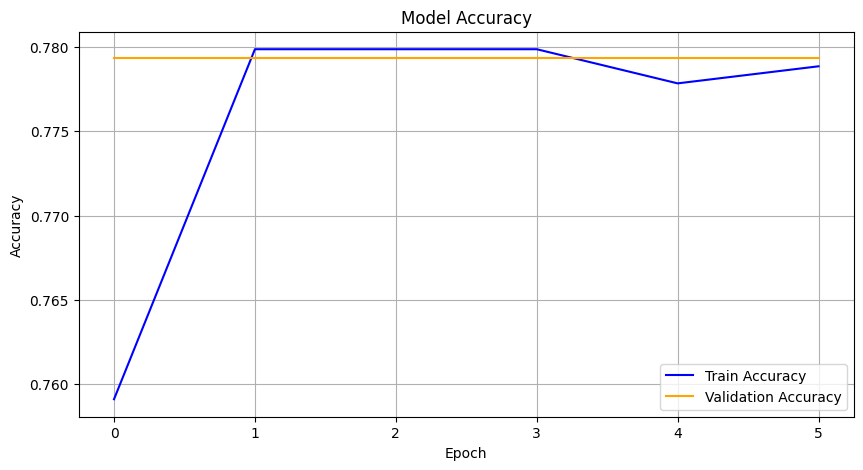

In [20]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()

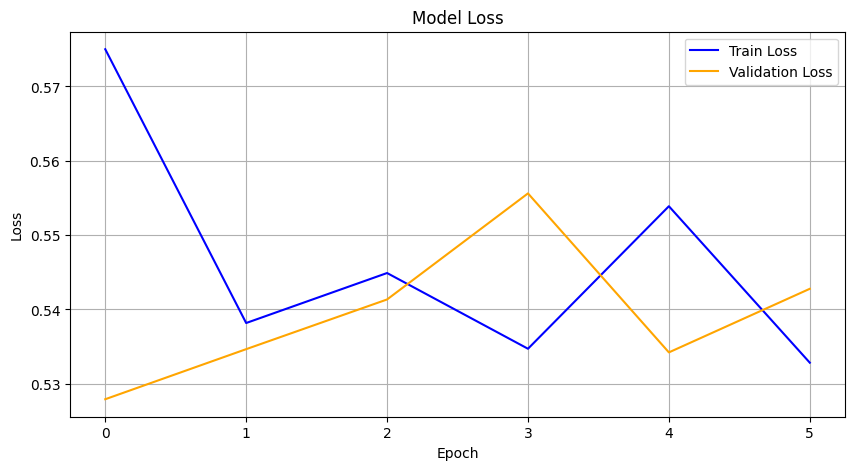

In [22]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [23]:
model.save("/kaggle/working/MP-2_Resnet50.h5")